Imports

In [1]:
!pip install opendatasets --upgrade

In [1]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
from PIL import Image
from numpy import array
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import models
from tensorflow.keras.optimizers import Adam, Adamax
from sklearn.metrics import confusion_matrix, classification_report
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn import preprocessing

Define Stratified Folds

In [2]:
sk_folds = StratifiedKFold(n_splits = 10, shuffle=True, random_state=0)

## Load and Process Image Data

In [4]:
dataset_url = 'https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: nusrathos
Your Kaggle Key: ··········


100%|██████████| 28.0M/28.0M [00:01<00:00, 22.6MB/s]


In [5]:
sample_image = Image.open('/content/alzheimer-mri-dataset/Dataset/Mild_Demented/mild.jpg')
ar = array(sample_image)
ar

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [6]:
print(ar.shape)

(128, 128)


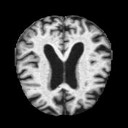

In [7]:
sample_image

In [8]:
path1 = []
path2 = []

for dirname, _, filenames in os.walk('/content/alzheimer-mri-dataset/Dataset/Non_Demented'):
    for filename in filenames:
        path1.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/alzheimer-mri-dataset/Dataset/Mild_Demented'):
    for filename in filenames:
        path2.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/alzheimer-mri-dataset/Dataset/Moderate_Demented'):
    for filename in filenames:
        path2.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('/content/alzheimer-mri-dataset/Dataset/Very_Mild_Demented'):
    for filename in filenames:
        path2.append(os.path.join(dirname, filename))

In [9]:
data = []
result = []
for path in path1:
    img = Image.open(path)
    img = np.array(img)
    data.append(np.array(img))
    result.append(0)

for path in path2:
    img = Image.open(path)
    img = np.array(img)
    data.append(np.array(img))
    result.append(1)

In [10]:
data = np.array(data)
data.shape

(6400, 128, 128)

In [11]:
result = np.array(result)
result = result.reshape((6400,))
result.shape

(6400,)

In [12]:
mean = np.mean(data, axis=(1,2), keepdims=True)
std = np.std(data, axis=(1,2), keepdims=True)
standardized_images = (data - mean) / std
print(standardized_images.shape)

(6400, 128, 128)


In [12]:
x_train,x_test,y_train,y_test = train_test_split(data,result,test_size=0.3,shuffle = True,random_state=42)

In [13]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(4480, 128, 128)
(1920, 128, 128)
(4480,)
(1920,)


In [ ]:
x_train = x_train[:261]
y_train = y_train[:261]
x_test = x_test[:112]
y_test = y_test[:112]

In [ ]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(261, 128, 128)
(112, 128, 128)
(261,)
(112,)


## Convolutional Neural Network for Image Data

In [18]:
# 10-fold cross validation for neural network trained on raw image data

from sklearn.preprocessing import MinMaxScaler

# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_num = 1
acc_per_fold = []

for train, test in sk_folds.split(x_train,y_train):
  # nsamples, nx, ny = x_train.shape
  # x_train = x_train.reshape((nsamples,nx*ny))

  # scaler = MinMaxScaler()
  train_x = x_train[train]
  test_x = x_train[test]
  train_y = y_train[train]
  test_y = y_train[test]
  # scaler.fit(train_x)
  # train_x = scaler.transform(train_x)
  # test_x = scaler.transform(test_x)

  model = models.Sequential()

  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128,128,1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.Flatten())
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

  history = model.fit(train_x,train_y, epochs=50, batch_size = 64)

  model.save('/content/image_model_fold_' + str(fold_num) + '.keras')

  scores = model.evaluate(test_x,test_y)
  acc_per_fold.append(scores[1]*100)

  fold_num += 1

plot_model(model, show_shapes=True, show_layer_names=True)

Epoch 1/50
63/63 [==============================] - 13s 24ms/step - loss: 4.6342 - accuracy: 0.5184
Epoch 2/50
12/63 [====>.........................] - ETA: 1s - loss: 0.6702 - accuracy: 0.5833

KeyboardInterrupt: ignored

In [ ]:
# average of the accuracy scores from cross-validation
print(np.average(acc_per_fold))

71.6239321231842


In [ ]:
print(acc_per_fold)

[77.77777910232544, 61.538463830947876, 88.46153616905212, 61.538463830947876, 84.61538553237915, 73.07692170143127, 73.07692170143127, 61.538463830947876, 65.38461446762085, 69.2307710647583]


In [19]:
# load model with highest accuracy
model = keras.models.load_model('/content/standardized_image_model_fold_1.keras')

In [20]:
# results of neural network trained on raw image data

preds = model.predict(x_test)
# y_pred = np.argmax(preds, axis=1)
y_pred = []
for pred in preds:
  if pred >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

classes = ['Normal','Demented']
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True)

ValueError: ignored

Prep Data to Fit Other Classifiers

In [ ]:
nsamples, nx, ny = data.shape
data = data.reshape((nsamples,nx*ny))

In [14]:
nsamples, nx, ny = x_train.shape
x_train = x_train.reshape((nsamples,nx*ny))

test_samples = x_test.shape[0]
x_test = x_test.reshape((test_samples,nx*ny))

In [15]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)

## Decision Tree Classifier for Image Data

In [40]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt_clf = DecisionTreeClassifier(random_state=0)

accuracy = cross_val_score(dt_clf, x_train, y_train, cv = sk_folds)
print('Accuracy', np.mean(accuracy), accuracy)
# recall = cross_val_score(dt_clf, data, result, cv=sk_folds, scoring='recall')
# print('Recall', np.mean(recall), recall)
# precision = cross_val_score(dt_clf, data, result, cv=sk_folds, scoring='precision')
# print('Precision', np.mean(precision), precision)
# f1 = cross_val_score(dt_clf, data, result, cv=sk_folds, scoring='f1')
# print('F1', np.mean(f1), f1)


Accuracy 0.7638392857142857 [0.74107143 0.78571429 0.77008929 0.78348214 0.75       0.75892857
 0.74553571 0.77678571 0.78125    0.74553571]


In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dt_clf = DecisionTreeClassifier(random_state=0)

dt_clf.fit(x_train, y_train)

DecisionTreeClassifier(random_state=0)

In [17]:
y_pred = dt_clf.predict(x_test)

In [22]:
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.00      0.00      0.00       975
    Demented       0.49      1.00      0.66       945

    accuracy                           0.49      1920
   macro avg       0.25      0.50      0.33      1920
weighted avg       0.24      0.49      0.32      1920



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Random Forest Classifier for Image Data

In [29]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=5, random_state=0)

accuracy = cross_val_score(rf_clf, x_train, y_train, cv = sk_folds)
print('Accuracy', np.mean(accuracy), accuracy)
# recall = cross_val_score(rf_clf, data, result, cv=sk_folds, scoring='recall')
# print('Recall', np.mean(recall), recall)
# precision = cross_val_score(rf_clf, data, result, cv=sk_folds, scoring='precision')
# print('Precision', np.mean(precision), precision)
# f1 = cross_val_score(rf_clf, data, result, cv=sk_folds, scoring='f1')
# print('F1', np.mean(f1), f1)

RandomForestClassifier(max_depth=5, random_state=0)

In [ ]:
rf_clf.fit(x_train,y_train)

In [30]:
y_pred = rf_clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.81      0.65      0.72       975
    Demented       0.70      0.84      0.76       945

    accuracy                           0.74      1920
   macro avg       0.75      0.75      0.74      1920
weighted avg       0.75      0.74      0.74      1920



## Logisitic Regression Classifier for Image Data

In [28]:
# Logistic regression classifier was not converging without normalizing the data first
from sklearn.linear_model import LogisticRegression
lr_clf = LogisticRegression(random_state=0, C=1e-5)

accuracy = cross_val_score(lr_clf, x_train, y_train, cv = sk_folds, verbose=0)
print('Accuracy', np.mean(accuracy), accuracy)
# recall = cross_val_score(lr_clf, x_train, y_train, cv=sk_folds, scoring='recall')
# print('Recall', np.mean(recall), recall)
# precision = cross_val_score(lr_clf, x_train, y_train, cv=sk_folds, scoring='precision')
# print('Precision', np.mean(precision), precision)

Accuracy 0.7252232142857143 [0.70982143 0.71651786 0.74553571 0.72991071 0.69419643 0.71651786
 0.77232143 0.72321429 0.70982143 0.734375  ]


In [ ]:
lr_clf.fit(x_train,y_train)

In [30]:
y_pred = lr_clf.predict(x_test)
print(classification_report(y_test, y_pred, target_names=classes))

              precision    recall  f1-score   support

      Normal       0.51      1.00      0.67       975
    Demented       0.00      0.00      0.00       945

    accuracy                           0.51      1920
   macro avg       0.25      0.50      0.34      1920
weighted avg       0.26      0.51      0.34      1920



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Prep Tabular Data

In [3]:
df = pd.read_csv('dementia_dataset.csv')

# drop unneccesary columns
df = df.drop(['Hand'],axis=1)
# df = df.drop(['MR Delay'],axis=1)
df = df.drop(['Subject ID'],axis=1)
df = df.drop(['MRI ID'],axis=1)
df = df.drop(['Visit'],axis=1)
# df = df.drop(['M/F'],axis=1)

# impute missing values
df['SES'].fillna((df['SES'].median()), inplace=True)
df['MMSE'].fillna((df['MMSE'].median()), inplace=True)

# turn catergorical variable into integer
df1 = pd.get_dummies(df['M/F'])
df = pd.concat([df, df1], axis=1).reindex(df.index)
df.drop('M/F', axis=1, inplace=True)

In [42]:
df

,Group,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,F,M
0,Nondemented,87,14,2.0,27.0,0.0,1987,0.696,0.883,0,1
1,Nondemented,88,14,2.0,30.0,0.0,2004,0.681,0.876,0,1
2,Demented,75,12,2.0,23.0,0.5,1678,0.736,1.046,0,1
3,Demented,76,12,2.0,28.0,0.5,1738,0.713,1.010,0,1
4,Demented,80,12,2.0,22.0,0.5,1698,0.701,1.034,0,1
...,...,...,...,...,...,...,...,...,...,...,...
368,Demented,82,16,1.0,28.0,0.5,1693,0.694,1.037,0,1
369,Demented,86,16,1.0,26.0,0.5,1688,0.675,1.040,0,1
370,Nondemented,61,13,2.0,30.0,0.0,1319,0.801,1.331,1,0
371,Nondemented,63,13,2.0,30.0,0.0,1327,0.796,1.323,1,0


In [4]:
def sum_CDR(n):
  if n == 0:
    return 0
  else:
    return 1

df['CDR'] = df['CDR'].apply(lambda x: sum_CDR(x))

In [44]:
df

,Group,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF,F,M
0,Nondemented,87,14,2.0,27.0,0,1987,0.696,0.883,0,1
1,Nondemented,88,14,2.0,30.0,0,2004,0.681,0.876,0,1
2,Demented,75,12,2.0,23.0,1,1678,0.736,1.046,0,1
3,Demented,76,12,2.0,28.0,1,1738,0.713,1.010,0,1
4,Demented,80,12,2.0,22.0,1,1698,0.701,1.034,0,1
...,...,...,...,...,...,...,...,...,...,...,...
368,Demented,82,16,1.0,28.0,1,1693,0.694,1.037,0,1
369,Demented,86,16,1.0,26.0,1,1688,0.675,1.040,0,1
370,Nondemented,61,13,2.0,30.0,0,1319,0.801,1.331,1,0
371,Nondemented,63,13,2.0,30.0,0,1327,0.796,1.323,1,0


In [5]:
labels = list(df['CDR'])
print(labels)

df = df.drop(['Group'],axis=1)
df = df.drop(['CDR'],axis=1)

df

[0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 

,MR Delay,Age,EDUC,SES,MMSE,eTIV,nWBV,ASF,F,M
0,0,87,14,2.0,27.0,1987,0.696,0.883,0,1
1,457,88,14,2.0,30.0,2004,0.681,0.876,0,1
2,0,75,12,2.0,23.0,1678,0.736,1.046,0,1
3,560,76,12,2.0,28.0,1738,0.713,1.010,0,1
4,1895,80,12,2.0,22.0,1698,0.701,1.034,0,1
...,...,...,...,...,...,...,...,...,...,...
368,842,82,16,1.0,28.0,1693,0.694,1.037,0,1
369,2297,86,16,1.0,26.0,1688,0.675,1.040,0,1
370,0,61,13,2.0,30.0,1319,0.801,1.331,1,0
371,763,63,13,2.0,30.0,1327,0.796,1.323,1,0


In [6]:
standard = preprocessing.scale(df)

In [7]:
standard

array([[-0.93771494,  1.30873772, -0.20813199, ..., -2.2657425 ,
        -1.15379808,  1.15379808],
       [-0.21761337,  1.43978716, -0.20813199, ..., -2.31650145,
        -1.15379808,  1.15379808],
       [-0.93771494, -0.26385558, -0.90439416, ..., -1.08378418,
        -1.15379808,  1.15379808],
       ...,
       [-0.93771494, -2.09854775, -0.55626308, ...,  0.98283006,
         0.86670278, -0.86670278],
       [ 0.2645553 , -1.83644887, -0.55626308, ...,  0.92481984,
         0.86670278, -0.86670278],
       [ 1.59603414, -1.57434999, -0.55626308, ...,  0.88131217,
         0.86670278, -0.86670278]])

In [8]:
x_train,x_test,y_train,y_test = train_test_split(standard,labels,test_size=0.3,shuffle = True,random_state=42)

In [9]:
print(x_train.shape)
print(x_test.shape)

(261, 10)
(112, 10)


## Decision Tree Classifer for Tabular Data

In [48]:
from sklearn.tree import DecisionTreeClassifier

dt_clf = DecisionTreeClassifier(random_state=0)

accuracy = cross_val_score(dt_clf, x_train, y_train, cv = sk_folds)
print('Accuracy', np.mean(accuracy), accuracy)

Accuracy 0.7925925925925926 [0.92592593 0.69230769 0.80769231 0.73076923 0.76923077 0.80769231
 0.61538462 0.84615385 0.92307692 0.80769231]


In [51]:
dt_clf.fit(x_train,y_train)

DecisionTreeClassifier(random_state=0)

In [52]:
y_pred = dt_clf.predict(x_test)

In [55]:
# with MR Delay
print(classification_report(y_test, y_pred, target_names=('Normal', 'Demented')))

              precision    recall  f1-score   support

      Normal       0.82      0.78      0.80        59
    Demented       0.77      0.81      0.79        53

    accuracy                           0.79       112
   macro avg       0.79      0.80      0.79       112
weighted avg       0.80      0.79      0.79       112



In [ ]:
# # without MR Delay
# print(classification_report(test_labels, y_pred1, target_names=classes))

              precision    recall  f1-score   support

    Demented       0.79      0.65      0.71        34
      Normal       0.74      0.85      0.79        40

    accuracy                           0.76        74
   macro avg       0.76      0.75      0.75        74
weighted avg       0.76      0.76      0.75        74



## Random Forest Classifer for Tabular Data

In [56]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(max_depth=5, random_state=0)

accuracy = cross_val_score(rf_clf, x_train, y_train, cv = sk_folds)
print('Accuracy', np.mean(accuracy), accuracy)

Accuracy 0.8084045584045585 [0.81481481 0.76923077 0.80769231 0.80769231 0.88461538 0.73076923
 0.73076923 0.76923077 0.88461538 0.88461538]


In [57]:
rf_clf.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, random_state=0)

In [58]:
y_pred_rf = rf_clf.predict(x_test)

In [60]:
print(classification_report(y_test, y_pred_rf, target_names=('Normal', 'Demented')))

              precision    recall  f1-score   support

      Normal       0.83      0.85      0.84        59
    Demented       0.83      0.81      0.82        53

    accuracy                           0.83       112
   macro avg       0.83      0.83      0.83       112
weighted avg       0.83      0.83      0.83       112



## Logistic Regression Classifer for Tabular Data

In [73]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression(random_state=0, C=1e-5)

accuracy = cross_val_score(lr_clf, x_train, y_train, cv = sk_folds, verbose=0)
print('Accuracy', np.mean(accuracy), accuracy)

Accuracy 0.5478632478632478 [0.55555556 0.57692308 0.57692308 0.57692308 0.57692308 0.57692308
 0.42307692 0.53846154 0.53846154 0.53846154]


In [74]:
lr_clf.fit(x_train,y_train)

LogisticRegression(C=1e-05, random_state=0)

In [75]:
y_pred_lr = lr_clf.predict(x_test)

In [76]:
print(classification_report(y_test, y_pred_lr, target_names=('Normal', 'Demented')))

              precision    recall  f1-score   support

      Normal       0.53      1.00      0.69        59
    Demented       0.00      0.00      0.00        53

    accuracy                           0.53       112
   macro avg       0.26      0.50      0.35       112
weighted avg       0.28      0.53      0.36       112



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Neural Network for Tabular Data

In [10]:
x_train = np.array(x_train)
y_train = np.array(y_train)

x_test = np.array(x_test)
y_test = np.array(y_test)

print(x_train.shape, y_train.shape)

(261, 10) (261,)


Epoch 1/30
4/4 [==============================] - 2s 8ms/step - loss: 0.6928 - accuracy: 0.5513
Epoch 2/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6831 - accuracy: 0.6581
Epoch 3/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6740 - accuracy: 0.7009
Epoch 4/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6643 - accuracy: 0.7479
Epoch 5/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6533 - accuracy: 0.7650
Epoch 6/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6406 - accuracy: 0.7735
Epoch 7/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6265 - accuracy: 0.7821
Epoch 8/30
4/4 [==============================] - 0s 5ms/step - loss: 0.6102 - accuracy: 0.7778
Epoch 9/30
4/4 [==============================] - 0s 5ms/step - loss: 0.5932 - accuracy: 0.7778
Epoch 10/30
4/4 [==============================] - 0s 7ms/step - loss: 0.5741 - accuracy: 0.7863
Epoch 11/30
4/4 [======================

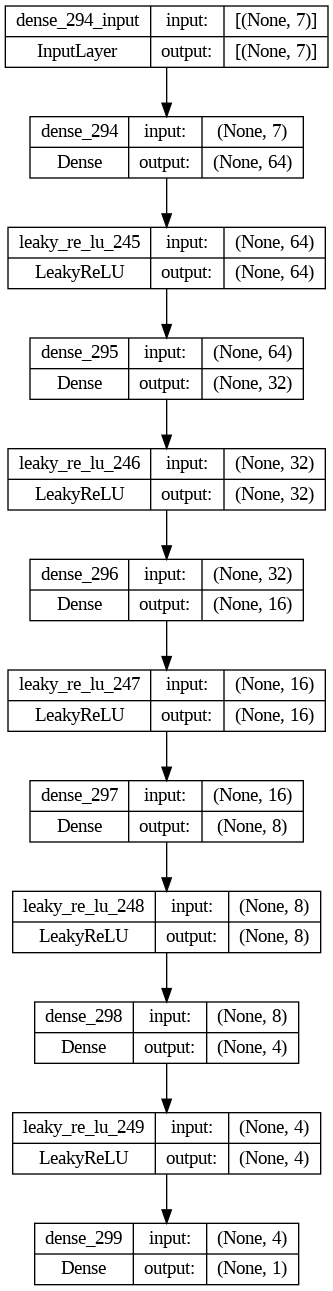

In [78]:
# 10-fold cross validation for neural network trained on tabular data

from sklearn.preprocessing import MinMaxScaler

# cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

fold_num = 1
acc_per_fold = []

for train, test in sk_folds.split(x_train,y_train):
  # nsamples, nx, ny = x_train.shape
  # x_train = x_train.reshape((nsamples,nx*ny))

  # scaler = MinMaxScaler()
  train_x = x_train[train]
  test_x = x_train[test]
  train_y = y_train[train]
  test_y = y_train[test]
  # scaler.fit(train_x)
  # train_x = scaler.transform(train_x)
  # test_x = scaler.transform(test_x)

  model_2 = models.Sequential()

  # model_2.add(layers.Input(11))
  model_2.add(layers.Dense(64, input_shape=(x_train.shape[1],)))
  model_2.add(layers.LeakyReLU(alpha=0.05))
  model_2.add(layers.Dense(32))
  model_2.add(layers.LeakyReLU(alpha=0.05))
  model_2.add(layers.Dense(16))
  model_2.add(layers.LeakyReLU(alpha=0.05))
  model_2.add(layers.Dense(8))
  model_2.add(layers.LeakyReLU(alpha=0.05))
  model_2.add(layers.Dense(4))
  model_2.add(layers.LeakyReLU(alpha=0.05))
  model_2.add(layers.Dense(1, activation='sigmoid'))

  model_2.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(), metrics = ['accuracy'])

  history = model_2.fit(train_x,train_y, epochs=30, batch_size = 64)

  model_2.save('/content/tabular_model_fold_' + str(fold_num) + '.keras')

  scores = model_2.evaluate(test_x,test_y)
  acc_per_fold.append(scores[1]*100)

  fold_num += 1

plot_model(model_2, show_shapes=True, show_layer_names=True)

In [79]:
# average of the accuracy scores from cross-validation
print(np.average(acc_per_fold))

81.96581065654755


In [60]:
print(acc_per_fold)

[85.18518805503845, 76.92307829856873, 76.92307829856873, 84.61538553237915, 84.61538553237915, 80.7692289352417, 76.92307829856873, 80.7692289352417, 88.46153616905212, 88.46153616905212]


In [11]:
# load model with highest accuracy
model_2 = keras.models.load_model('/content/standardized_tabular_model_fold_9.keras')

4/4 [==============================] - 3s 5ms/step
              precision    recall  f1-score   support

      Normal       0.84      0.81      0.83        59
    Demented       0.80      0.83      0.81        53

    accuracy                           0.82       112
   macro avg       0.82      0.82      0.82       112
weighted avg       0.82      0.82      0.82       112



<Axes: >

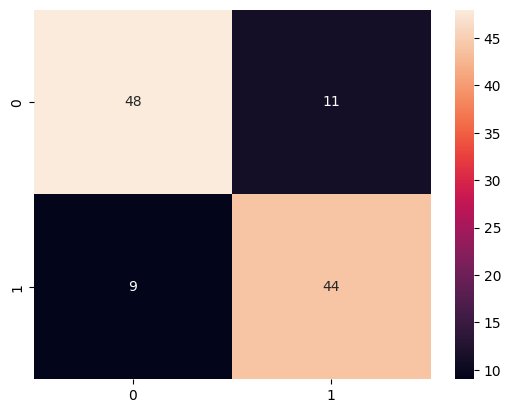

In [12]:
# results of neural network trained on raw image data

preds = model_2.predict(x_test)
# y_pred = np.argmax(preds, axis=1)
y_pred = []
for pred in preds:
  if pred >= 0.5:
    y_pred.append(1)
  else:
    y_pred.append(0)

classes = ['Normal','Demented']
print(classification_report(y_test, y_pred, target_names=classes))

cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True)